In [0]:
# Prelimiaries: Install Gerrychain
!pip install gerrychain

4/wQG8qOFHR9fTDqOwu2kFX0c6OvjB4dnG9TIKceAAy8kiDYnHuHIvMio

In [0]:
#from google.colab import files
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
# Required packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
import pandas as pd
import numpy as np
# import geopandas as gp
import networkx as nx
import matplotlib.pyplot as plt
# from functools import partial
from tqdm.auto import tqdm

In [0]:
# In this cell I have defined functions for calculating Polsby-Popper and population max-min for a grid object

def plot_districts(grid1):
  """
  Plots the districts of a Grid object.
  
  Parameters:
    grid1: a Networkx Graph object, built as a GerryChain grid
  """
  # Get a sequence of assignments (rather than the stored dictionary)
  districts = np.array([grid1.assignment[node] for node in grid1.graph.nodes()])
  
  # The Kamada-Kawai method for nx drawing works best in this case
  nx.drawing.nx_pylab.draw_kamada_kawai(grid1.graph, node_size=20, node_color=districts)

def polsby_popper_grid(grid1):
  """
  Computes the Polsby-Popper score for each district in the grid.

  Parameters:
    grid1: a Networkx Graph object, built as a GerryChain grid
  
  Returns:
    scores (ndarray): The scores of each district in the grid

  """
  # Set parameters
  s = set(grid1.assignment.values())
  n = len(s)
  perimeters = np.zeros(n)
  areas = np.array([sum(grid1.graph.nodes[node]['area'] for node in grid1.graph.nodes if grid1.assignment[node] == i) for i in s])
  
  # Iterate through each node in the graph
  for node1 in grid1.graph.nodes:
    district = grid1.assignment[node1]
    if grid1.graph.nodes[node1]['boundary_node']:
      # Perimeter along boundary
      perimeters[district] += grid1.graph.nodes[node1]['boundary_perim']
    for node2 in grid1.graph[node1].keys():
      if district != grid1.assignment[node2]:
        # Internal perimeter
        perimeters[district] += grid1.graph[node1][node2]['shared_perim']
  
  # Compute the Polsby-Popper score for each district
  return 4*np.pi*areas/perimeters**2

def district_populations(grid1):
    """
    Computes the populations the districts in a grid.

    Parameters:
      grid1: a Networkx Graph object, built as a GerryChain grid

    Returns:
      pops (ndarray)
    """
    # Set parameters
    s = set(grid1.assignment.values()) 
    n = len(s)
    pops = np.zeros(n)

    # Iterate through each node and tally its population in the appropriate index of "populations"
    for node in grid1.graph.nodes:
      pops[grid1.assignment[node]] += grid1.graph.nodes[node]["population"]

    return pops

def population_maxmin(grid1, relative=False):
    """
    Computes the absolute difference between the populations of the most populous and least populous districts in a grid.

    Parameters:
      grid1: a Networkx Graph object, built as a GerryChain grid
      relative: if True, returns difference as a percentage of average district population

    Returns:
      maxmin (int): The largest population difference. Returns a float (percentage) iff relative is True.
    """
    pops = district_populations(grid1)

    # Perform calculations
    av = np.mean(pops)
    maxmin = np.max(pops) - np.min(pops)

    # Return the difference of the maximum and minimum populations
    if relative:
      return maxmin/av
    else:
      return maxmin

In [0]:
# This is how to build a cusom acceptance function to work with GerryChain's MarkovChain object

class CustomAccept:
    def __init__(self, weights, k=1):
      """
      Initialize an acceptance function with a particular set of weights for
      0) Compactness (Polsby-Popper)
      1) Population Max-min 

      Parameters:
        weights (ndarray): Length 2 ndarray specifying weights in [0, 1) for the two measures above
                          Larger weights indicate greater importance
        k (float): strictness of the acceptance function
      """
      # User-defined parameters
      self.weights = weights/np.mean(weights) # Intended to be mean-1
      self.k = k

    def fitness(self, grid1):
      """
      Determines the absolute fitness of a partition in terms of its compactness 
      and population max-min, using the given weights and scaling.

      Parameters:
        grid1: a Networkx Graph object, built as a GerryChain grid

      Returns:
        w (float): >= 0, a float indicating the "fitness" of the partition. 0 is best
      """
      # Get raw scores
      pp = np.mean(polsby_popper_grid(grid1))
      mm = population_maxmin(grid1, relative=True)

      # Calculate our weighted coefficient (lower value is better)
      return self.k*np.mean(self.weights * np.array([1.273*(0.786-pp), 5*mm]))

      # 0.786, or pi/4, is the maximum possible Polsby-Popper score for a grid district
      # Subtract pp from 0.786 so that good scores are represented by 0

    def __call__(self, grid1, absolute=True)):
      """
      A probabilistic acceptance function which calculates how acceptable a 
      partition is and returns a boolean value indicating whether or not to accept 
      the partition. 

      Parameters:
        grid1: a Networkx Graph object, built as a GerryChain grid
        absolute (bool): default True; whether to calculate absolute fitness or 
                        fitness relative to the previous partition.

      Returns:
        accept (bool): True or False (whether to accept the grid)
      """

      # Use probabilistic acceptance
      if absolute:
        return np.exp(-self.fitness(grid1)) > np.random.random(1)
      else:
        return np.exp(self.fitness(grid1.parent)-self.fitness(grid1)) > np.random.random(1)
        # If the new partition is "better," then it will be accepted with probability 1
        # Otherwise, there is some probability that it will be rejected, dependent on the 

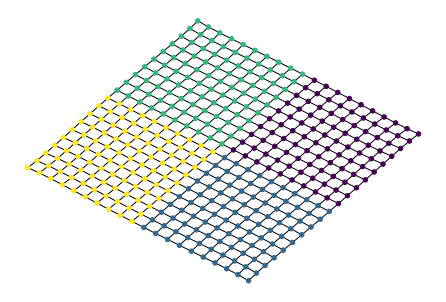

In [27]:
# Create and plot the grid and its initial partition
grid1 = grid.Grid((20,20))
plot_districts(grid1)

In [28]:
polsby_popper_grid(grid1)

array([0.78539816, 0.78539816, 0.78539816, 0.78539816])

In [29]:
district_populations(grid1), population_maxmin(grid1)

(array([100., 100., 100., 100.]), 0.0)

In [0]:
# Create a Markov Chain for single flips based on this grid, with a uniform acceptance criterion
chain1 = MarkovChain(
    proposal = proposals.propose_random_flip,
    constraints=[constraints.single_flip_contiguous],
    accept=accept.always_accept,
    initial_state=grid1,
    total_steps=1000
)

# Create a Markov Chain with an acceptance criterion based on maintaining compact districts and population proportionality
chain2 = MarkovChain(
    proposal = proposals.propose_random_flip,
    constraints=[constraints.single_flip_contiguous],
    accept=CustomAccept(np.array([1,1]), k=2),
    initial_state=grid1,
    total_steps=1000
)

# Crate a Markov Chain with a relative acceptance criterion that always accepts "better" iterations and probabilistically accepts worse ones
chain3 = MarkovChain(
    proposal = proposals.propose_random_flip,
    constraints=[constraints.single_flip_contiguous],
    accept=CustomAccept(np.array([1,1]), k=3),
    initial_state=grid1,
    total_steps=1000
)



In [0]:
# Create a data frame of scores from a chain (generally about 1 min for 1e4 iterations)
def record_pp_mm(chain):
  """
  Create a pd.DataFrame containing the polsby-popper and population_max_min data for each iteration in the Markov Chain
  """
  return pd.DataFrame([ np.concatenate((polsby_popper_grid(partition), district_populations(partition))) for partition in tqdm(chain) ])

In [0]:
def plot_statistics_grid(d, acceptance_type="Uniform Acceptance"):
  """
  Makes 4 plots to describe how compactness and population equality change as the 
  Markov chain iterates, and then prints out statistics for Polsby-Popper and 
  Population Max-Min.

  Parameters:
    d (pd.DataFrame): a data frame describing the Polsby-Popper and pop max-min statistics at each iteration

  Returns:
    pp (float): The mean mean Polsby-Popper score over the DataFrame
    mm (float): The mean relative max-min population score over the DataFrame
  """
  # Plot the Polsby-Popper score of each district
  for i in range(4):
    plt.plot(d.iloc[:, i], label="District {}".format(i))
    plt.title("Degradation of Polsby-Popper Scores with {}".format(acceptance_type))
    plt.ylabel("Polsy-Popper Score")
    plt.xlabel("Iteration")
    plt.legend(loc="upper right")

  plt.show()

  # Plot the population of each district
  for i in range(4):
    plt.plot(d.iloc[:, i+4], label="District {}".format(i))
    plt.title("Loss of Population Proportionality with {}".format(acceptance_type))
    plt.ylabel("Population")
    plt.xlabel("Iteration")
    plt.legend(loc="upper right")

  plt.show()

  # Plot the mean Polsby-Popper score at each iteration
  plt.plot(np.mean(d.iloc[:, :4], axis=1), label="Mean Score")
  plt.title("Degradation of Mean Polsby-Popper Score with {}".format(acceptance_type))
  plt.ylabel("Polsy-Popper Score")
  plt.xlabel("Iteration")
  plt.legend(loc="upper right")

  plt.show()

  # Plot the population max-min at each iteration
  plt.plot((np.max(d.iloc[:, 4:], axis=1)-np.min(d.iloc[:, 4:], axis=1))/100, label="Relative Max-Min")
  plt.title("Loss of Population Proportionality with {}".format(acceptance_type))
  plt.ylabel("Population")
  plt.xlabel("Iteration")
  plt.legend(loc="upper right")

  plt.show()

  # Calculate some statistics

  # Mean Polsby-Popper
  print("Polsby-Popper Scores")
  c1 = d.iloc[:, :4].mean(axis=1)
  print(c1.describe())

  # Population max-min
  print("Population Max-Min Scores")
  c2 = (np.max(d.iloc[:, 4:], axis=1)-np.min(d.iloc[:, 4:], axis=1))/100
  print(c2.describe())

  return c1.mean(), c2.mean()

In [50]:
d.shape

(1000, 8)

In [0]:
def percent_acceptance(d):
  counter = 0
  for i in range(1, d.shape[0]):
    if np.allclose(d.iloc[i, :], d.iloc[i-1, :]):
      counter += 1
  return (d.shape[0]-counter)/d.shape[0]

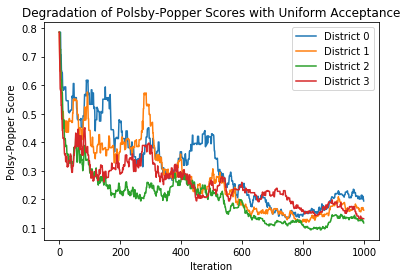

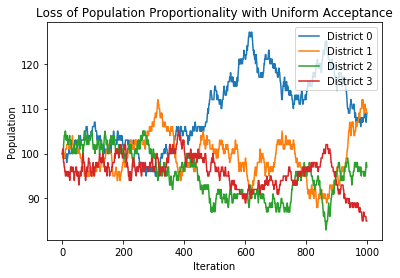

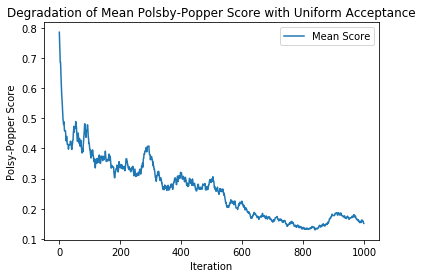

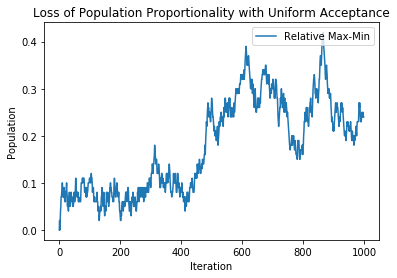

Polsby-Popper Scores
count    1000.000000
mean        0.262976
std         0.104119
min         0.129640
25%         0.170599
50%         0.264767
75%         0.335068
max         0.785398
dtype: float64
Population Max-Min Scores
count    1000.00000
mean        0.17673
std         0.09874
min         0.00000
25%         0.08000
50%         0.18000
75%         0.26000
max         0.42000
dtype: float64


(0.2629763822188551, 0.1767299999999999)

In [45]:
d = record_pp_mm(chain1)
plot_statistics_grid(d)

In [58]:
percent_acceptance(d)

1.0

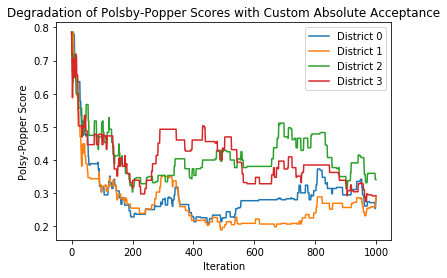

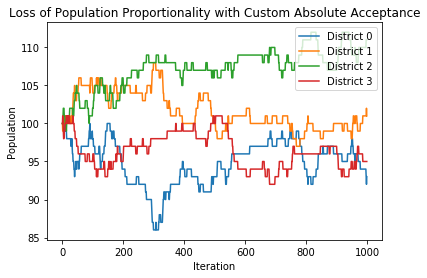

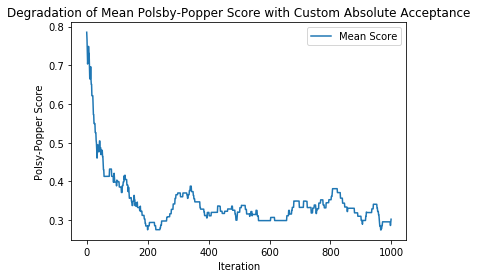

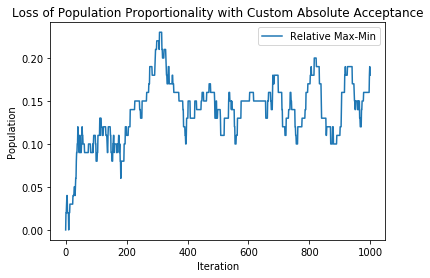

Polsby-Popper Scores
count    1000.000000
mean        0.345324
std         0.067971
min         0.274517
25%         0.309842
50%         0.329166
75%         0.354977
max         0.785398
dtype: float64
Population Max-Min Scores
count    1000.000000
mean        0.137900
std         0.036701
min         0.000000
25%         0.120000
50%         0.140000
75%         0.160000
max         0.230000
dtype: float64


(0.3453236363242691, 0.13789999999999994)

In [46]:
d2 = record_pp_mm(chain2)
plot_statistics_grid(d2, "Custom Absolute Acceptance")

In [59]:
percent_acceptance(d2)

0.252

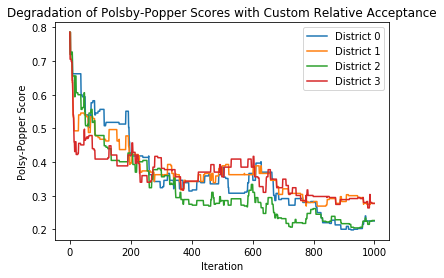

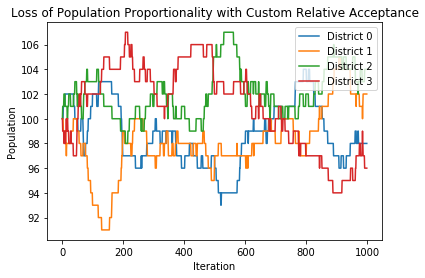

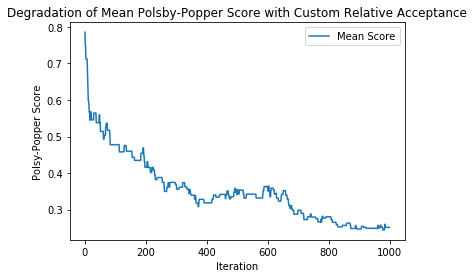

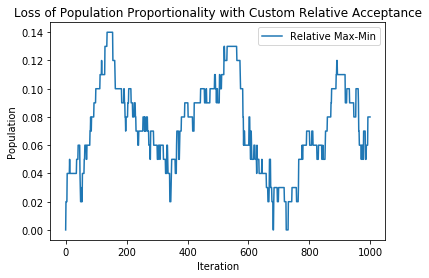

Polsby-Popper Scores
count    1000.000000
mean        0.352525
std         0.089883
min         0.244448
25%         0.280274
50%         0.340010
75%         0.382134
max         0.785398
dtype: float64
Population Max-Min Scores
count    1000.000000
mean        0.073060
std         0.030874
min         0.000000
25%         0.050000
50%         0.070000
75%         0.100000
max         0.140000
dtype: float64


(0.3525245767365889, 0.07306000000000017)

In [49]:
d3 = record_pp_mm(chain3)
plot_statistics_grid(d3, "Custom Relative Acceptance")

In [60]:
percent_acceptance(d3)

0.216

In [23]:
import inspect
print(inspect.getsource(MarkovChain))
print(inspect.getsource(Partition))
print(inspect.getsource(grid.Grid))

class MarkovChain:
    """
    MarkovChain is an iterator that allows the user to iterate over the states
    of a Markov chain run.

    Example usage:

    .. code-block:: python

        chain = MarkovChain(proposal, constraints, accept, initial_state, total_steps)
        for state in chain:
            # Do whatever you want - print output, compute scores, ...

    """

    def __init__(self, proposal, constraints, accept, initial_state, total_steps):
        """
        :param proposal: Function proposing the next state from the current state.
        :param constraints: A function with signature ``Partition -> bool`` determining whether
            the proposed next state is valid (passes all binary constraints). Usually
            this is a :class:`~gerrychain.constraints.Validator` class instance.
        :param accept: Function accepting or rejecting the proposed state. In the most basic
            use case, this always returns ``True``. But if the user wanted to use a
    